In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
#why are we using a modulo operator ever?
#what is role of gpe_bl and gpi_bl, will likely require reading...

#the manella paper has it set up that even upon action plan initation, only one thalamic unit is ever becoming active...
#if we assume that the most salient input will always have an salience above 50% of the maximal input this become easier, than a salience of 0.5 just needs to be set st. it completly blocks all other action plans

#things changed on november 9th
# - updated non-linearity to actually apply a non-linearity
# - set so tonic GPi activity keeps Tha activity close to 0...
# - set w_inp_ctx st that the maximal driven activity cannot be greater than 0.5, thus the recurrant cortical activity can be of equal strength or greater... prevents switching from a selected action plan
#   - currently set so that a salience of 1 drives a striatal response of 0.4
#also making note, it may be helpful if we have a constant amount of salience... for example if each node has its salience set as the posterior probability that it will produce the least error, we can have a constant amount of salience coming in, this cant make anything more difficult at least

# - maybe we can get around the cortex feedback issue if we normalize all cortical feedback to have a sum of one? This makes it so the input and cortex recurrant activity are actually the same input
# - also maybe we normalize everything so the largest salience is always at the same number? also makes things easier

[[0.         0.         0.        ]
 [0.03997868 0.03997868 0.03997868]
 [0.03598659 0.03598659 0.03598659]
 [0.03638527 0.03638527 0.03638527]
 [0.03634546 0.03634546 0.03634546]
 [0.03634943 0.03634943 0.03634943]
 [0.03634904 0.03634904 0.03634904]
 [0.03634907 0.03634907 0.03634907]
 [0.03634907 0.03634907 0.03634907]
 [0.03634907 0.03634907 0.03634907]
 [0.03634907 0.03634907 0.03634907]
 [0.03634907 0.03634907 0.03634907]
 [0.03634907 0.03634907 0.03634907]
 [0.03634907 0.03634907 0.03634907]
 [0.03634907 0.03634907 0.03634907]
 [0.03634907 0.03634907 0.03634907]
 [0.2320595  0.37683451 0.30621653]
 [0.21346029 0.34725288 0.28156254]
 [0.21523476 0.34985166 0.28383091]
 [0.21506553 0.34962357 0.28362234]
 [0.21508167 0.34964359 0.28364152]
 [0.21508013 0.34964183 0.28363975]
 [0.21508028 0.34964198 0.28363991]
 [0.21508026 0.34964197 0.2836399 ]
 [0.21508026 0.34964197 0.2836399 ]
 [0.21508026 0.34964197 0.2836399 ]
 [0.21508026 0.34964197 0.2836399 ]
 [0.21508026 0.34964197 0.28

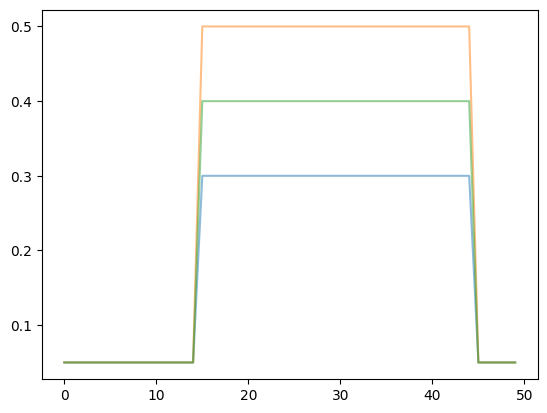

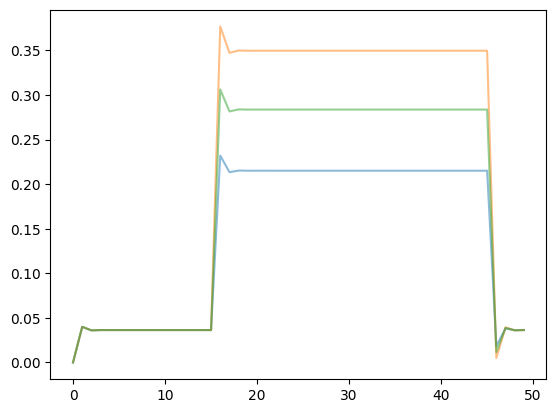

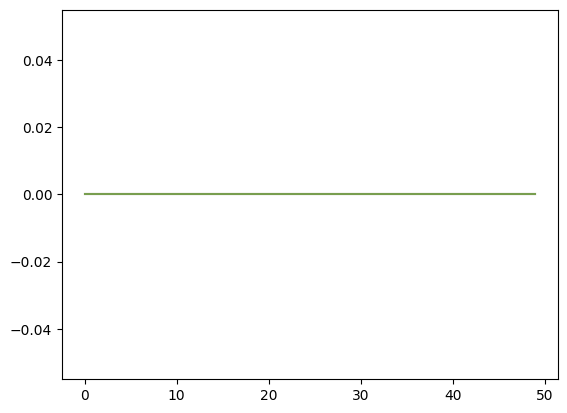

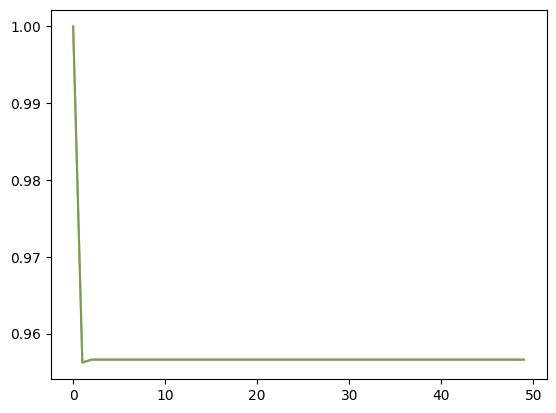

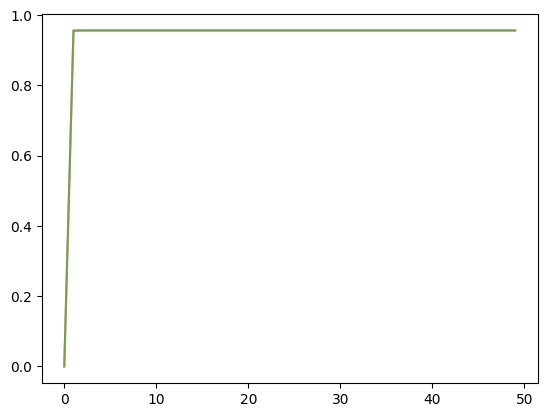

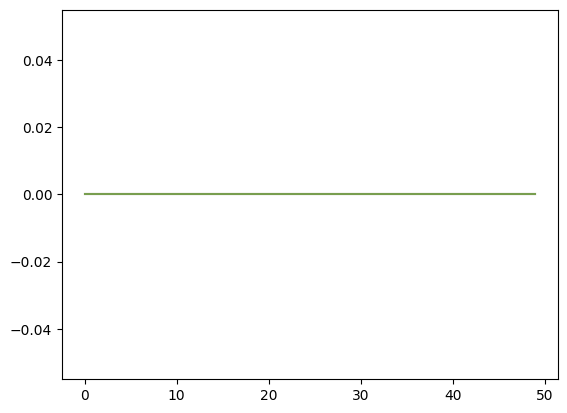

In [22]:
class b_ganglia:
    def __init__(self,n_loops,time_steps):

        self.n_loops=n_loops

        #activations for all units
        self.a_sd1 = np.zeros((time_steps, n_loops))
        self.a_sd2 = np.zeros((time_steps, n_loops))
        self.a_stn = np.zeros((time_steps, n_loops))
        self.a_gpi = np.ones((time_steps, n_loops))
        self.a_gpe = np.zeros((time_steps, n_loops))
        self.a_tha = np.zeros((time_steps, n_loops))
        self.a_ctx = np.zeros((time_steps, n_loops))

        #vector to hold the inputs...
        self.a_inp = np.ones((time_steps, n_loops)) * 0.05
        for i in range(30):
            self.a_inp[i+15] =  [0.3,0.5,0.4]

        #variable to keep track of what step we are currently on
        self.c = 0




    #uses euler integration to calculate the activation at each unit in the model of the basal ganglia 
    def step(self, i, da):

        #likely easier to just define the parameters inside this function...
        
        dt = 0.001
        tau = 0.01
        #time constant 
        h= dt/tau

        #define the weight matrices
        w_inp_sd1 = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 8
        w_inp_stn = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 0
        w_ctx_sd1 = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 0
        w_ctx_sd2 = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 0
        w_ctx_stn = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 0 
        w_sd1_gpi = np.array([[1,0,0],[0,1,0],[0,0,1]]) * -0 
        w_sd2_gpe = np.array([[1,0,0],[0,1,0],[0,0,1]]) * -0
        w_stn_gpi = np.ones((self.n_loops,self.n_loops)) * 0
        w_stn_gpe = np.ones((self.n_loops,self.n_loops)) * 0
        w_gpe_stn = np.ones((self.n_loops,self.n_loops)) * -0
        w_gpe_gpi = np.ones((self.n_loops,self.n_loops)) * -0
        w_gpi_tha = np.array([[1,0,0],[0,1,0],[0,0,1]]) * -0
        w_tha_ctx = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 0 


        #define the sensitivies to dopamine and normal response
        sd1_bl = 0.1
        sd1_DA = 0.9
        sd2_bl = 0.1
        sd2_DA = 20
        gpi_bl = 0.1
        gpe_bl = 0.1
        

        #input to sd1 from cortex modulated by dopamine, this completes the loop
        self.a_sd1[i+1] = self.non_lin(h * (-1 * self.a_sd1[i] + (sd1_bl + sd1_DA * da) * (np.matmul(self.a_ctx[i], w_ctx_sd1)+ np.matmul(self.a_inp[i], w_inp_sd1))))

        #input to sd2 modulated by dopamine
        self.a_sd2[i+1] = self.non_lin(h * (-1 * self.a_sd2[i] + (1/(sd2_bl + sd2_DA * da)) * (np.matmul(self.a_ctx[i], w_ctx_sd2)))) 

        #input to stn from ctx and gpe
        self.a_stn[i+1] = self.non_lin(h * (-1 * self.a_stn[i] + (np.matmul(self.a_ctx[i], w_ctx_stn)) + np.matmul(self.a_gpe[i], w_gpe_stn)) + (np.matmul(self.a_inp[i], w_inp_stn)))

        #input to gpe from stn and sd2
        self.a_gpe[i+1] = self.non_lin(h * (-1 * self.a_gpe[i]) + (np.matmul(self.a_sd2[i], w_sd2_gpe)) + (np.matmul(self.a_stn[i], w_stn_gpe)))

        #input to gpi from strd1, stn, and gpe 
        self.a_gpi[i+1] = self.non_lin(h * (-1 * self.a_gpi[i] + (np.matmul(self.a_sd1[i], w_sd1_gpi))   + (np.matmul(self.a_stn[i], w_stn_gpi)) + (np.matmul(self.a_gpe[i], w_gpe_gpi))+20))

        #input to thalamus from gpi 
        self.a_tha[i+1] = self.non_lin(h * (-1 * self.a_gpi[i] + (np.matmul(self.a_gpi[i], w_gpi_tha)) + 20))

        #input to cortex from gpi, also going to give some tonic excitation
        self.a_ctx[i+1] = self.non_lin(h * (-1 * self.a_ctx[i] + (np.matmul(self.a_tha[i], w_tha_ctx))))


        
        self.c += 1

        return None

    #non-linearity to generate activations
    def non_lin(self,vec):

        #apply non-linearity
        x = np.tanh(1*(vec)+0)
        
        #set any negative values to 0
        for i in range(self.n_loops):
            if x[i] < 0:
                x[i] = 0
        
        return x

    def run(self, steps):
        
        for i in range(steps):
            self.step(i=self.c,da=1)

    def display(self):
        
        plt.figure()
        plt.plot(self.a_inp,alpha=0.5)

        plt.figure()
        plt.plot(self.a_sd1,alpha=0.5)

        plt.figure()
        plt.plot(self.a_stn,alpha=0.5)

        plt.figure()
        plt.plot(self.a_gpi,alpha=0.5)

        plt.figure()
        plt.plot(self.a_tha,alpha=0.5)

        plt.figure()
        plt.plot(self.a_ctx,alpha=0.5)

        return None


bg = b_ganglia(3,50)

bg.run(49)
print(bg.a_sd1)
bg.display()
